In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# df = pd.read_csv('/content/drive/My Drive/DSF/MFactorization.csv')
df = pd.read_csv('/content/drive/My Drive/dsf/Project/data/MatrixFactorizationNew.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
orig_df = df.copy()

# Helpers

In [0]:
import scipy.sparse as sp
import numpy as np

In [0]:
def threshold_interactions_df(df, row_name, col_name, row_min, col_min):
    """Limit interactions df to minimum row and column interactions.
    Parameters
    ----------
    df : DataFrame
        DataFrame which contains a single row for each interaction between
        two entities. Typically, the two entities are a user and an item.
    row_name : str
        Name of column in df which corresponds to the eventual row in the
        interactions matrix.
    col_name : str
        Name of column in df which corresponds to the eventual column in the
        interactions matrix.
    row_min : int
        Minimum number of interactions that the row entity has had with
        distinct column entities.
    col_min : int
        Minimum number of interactions that the column entity has had with
        distinct row entities.
    Returns
    -------
    df : DataFrame
        Thresholded version of the input df. Order of rows is not preserved.
    Examples
    --------
    df looks like:
    user_id | item_id
    =================
      1001  |  2002
      1001  |  2004
      1002  |  2002
    thus, row_name = 'user_id', and col_name = 'item_id'
    If we were to set row_min = 2 and col_min = 1, then the returned df would
    look like
    user_id | item_id
    =================
      1001  |  2002
      1001  |  2004
    """

    n_rows = df[row_name].unique().shape[0]
    n_cols = df[col_name].unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_rows*n_cols) * 100
    print('Starting interactions info')
    print('Number of rows: {}'.format(n_rows))
    print('Number of cols: {}'.format(n_cols))
    print('Sparsity: {:4.3f}%'.format(sparsity))

    done = False
    while not done:
        starting_shape = df.shape[0]
        col_counts = df.groupby(row_name)[col_name].count()
        df = df[~df[row_name].isin(col_counts[col_counts < col_min].index.tolist())]
        row_counts = df.groupby(col_name)[row_name].count()
        df = df[~df[col_name].isin(row_counts[row_counts < row_min].index.tolist())]
        ending_shape = df.shape[0]
        if starting_shape == ending_shape:
            done = True

    n_rows = df[row_name].unique().shape[0]
    n_cols = df[col_name].unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_rows*n_cols) * 100
    print('Ending interactions info')
    print('Number of rows: {}'.format(n_rows))
    print('Number of columns: {}'.format(n_cols))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [0]:
def get_df_matrix_mappings(df, row_name, col_name):
    """Map entities in interactions df to row and column indices
    Parameters
    ----------
    df : DataFrame
        Interactions DataFrame.
    row_name : str
        Name of column in df which contains row entities.
    col_name : str
        Name of column in df which contains column entities.
    Returns
    -------
    rid_to_idx : dict
        Maps row ID's to the row index in the eventual interactions matrix.
    idx_to_rid : dict
        Reverse of rid_to_idx. Maps row index to row ID.
    cid_to_idx : dict
        Same as rid_to_idx but for column ID's
    idx_to_cid : dict
    """


    # Create mappings
    rid_to_idx = {}
    idx_to_rid = {}
    for (idx, rid) in enumerate(df[row_name].unique().tolist()):
        rid_to_idx[rid] = idx
        idx_to_rid[idx] = rid

    print('*********')
    print('Storing products in order of popularity -')
    tmp_counts = df['Item Description'].value_counts()
    item_descs = tmp_counts.index.to_list()
    print('*********')

    cid_to_idx = {}
    idx_to_cid = {}
    #for (idx, cid) in enumerate(df[col_name].unique().tolist()):
    for (idx, cid) in enumerate(item_descs):
        cid_to_idx[cid] = idx
        idx_to_cid[idx] = cid

    return rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid


def df_to_matrix(df, row_name, col_name):
    """Take interactions dataframe and convert to a sparse matrix
    Parameters
    ----------
    df : DataFrame
    row_name : str
    col_name : str
    Returns
    -------
    interactions : sparse csr matrix
    rid_to_idx : dict
    idx_to_rid : dict
    cid_to_idx : dict
    idx_to_cid : dict
    """

    rid_to_idx, idx_to_rid,\
        cid_to_idx, idx_to_cid = get_df_matrix_mappings(df,
                                                        row_name,
                                                        col_name)

    def map_ids(row, mapper):
        return mapper[row]

    I = df[row_name].apply(map_ids, args=[rid_to_idx]).as_matrix()
    J = df[col_name].apply(map_ids, args=[cid_to_idx]).as_matrix()
    V = np.ones(I.shape[0])
    interactions = sp.coo_matrix((V, (I, J)), dtype=np.float64)
    interactions = interactions.tocsr()
    return interactions, rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid


def train_test_split(interactions, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    Params
    ------
    interactions : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all
        users are considered.
    """
    # Note: likely not the fastest way to do things below.
    train = interactions.copy().tocoo()
    test = sp.lil_matrix(train.shape)

    if fraction:
        try:
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0],
                replace=False,
                size=np.int64(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*split_count, fraction))
            raise
    else:
        user_index = range(train.shape[0])

    train = train.tolil()

    for user in user_index:
        test_interactions = np.random.choice(interactions.getrow(user).indices,
                                        size=split_count,
                                        replace=False)
        train[user, test_interactions] = 0.
        # These are just 1.0 right now
        test[user, test_interactions] = interactions[user, test_interactions]


    # Test and training are truly disjoint
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index

# MATRIX GENERATION

In [0]:
df.head()

,Receipt Number,Date,Transaction Time,Customer Number,Loyalty ID,Store #,Store Name,Item Number,Item Description,Net Sales Units,Department Code,Department Name,Class Code,Class Name,Fineline Code,Fineline Name,Return Code
0,D70801,4/1/2017,7:02:55,290074,1926165091,O,15863 COPIAGUE,7158314,ACE FERT 4STEP 5M,1,70,"LAWN, GARDEN & FARM SUPPLIES",744,FERTILIZERS,74401,LAWN (DRY BAG),N
1,D70801,4/1/2017,7:02:55,290074,1926165091,O,15863 COPIAGUE,IS117235,7158314 $20 INST SAVINGS,-1,I1,ACE REWARDS INSTANT SAVINGS,IS1,ACE COUPON/CREDIT ITEMS,IS106,ACE COUPON/CREDIT ITEMS,N
2,A39683,4/1/2017,7:14:22,191376,1914355100,F,14822 NORTHPORT,78832,"ACE DECK NAIL16D3.5""ST1#",1,56,FASTENERS,574,PACKAGE NAILS,57403,1 & 5LB NAILS AND STAPLES,N
3,A39683,4/1/2017,7:14:22,191376,1914355100,F,14822 NORTHPORT,9269862,CMN Donations,1,DO,DONTATIONS,DON,DONATIONS,NaN,BLANK,N
4,D70802,4/1/2017,7:21:00,500851,1981639897,O,15863 COPIAGUE,1005412,CLEANR GLAS19OZ SPRAYWAY,2,10,CLEANING SUPPLIES,105,GLASS/PLASTIC CLEANERS,10504,GLASS CLEANER (AEROSOL),N


In [0]:
# df.drop(columns=['Unnamed: 0'], inplace=True)

In [0]:
df['Item Number'] = df['Item Number'].astype(str)
df['Loyalty ID'] = df['Loyalty ID'].astype(int)

In [0]:
# Meaning each customer has bought at least 60 products and each product has at least been bought 140 times, experiment with this
interactions = threshold_interactions_df(df,'Loyalty ID','Item Description', 60,140)

Starting interactions info
Number of rows: 348993
Number of cols: 100306
Sparsity: 0.035%
Ending interactions info
Number of rows: 4611
Number of columns: 5339
Sparsity: 4.375%


In [0]:
df.shape, interactions.shape

((12205038, 17), (1077032, 17))

In [0]:
likes, cid_to_idx, idx_to_cid,\
pid_to_idx, idx_to_pid = df_to_matrix(interactions, 'Loyalty ID', 'Item Description')

*********
Storing products in order of popularity -
*********


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
train, test, user_index = train_test_split(likes, 60, fraction=0.2)

In [0]:
eval_train = train.copy()
non_eval_users = list(set(range(train.shape[0])) - set(user_index))

In [0]:
eval_train = eval_train.tolil()

In [0]:
cnt = 0
for u in non_eval_users:
    cnt+=1
    if cnt % 1000 == 0:
      print (cnt)
    eval_train[u, :] = 0

In [0]:
eval_train = eval_train.tocsr()

In [0]:
pid_to_idx

{'FASTENERS': 0,
 'CMN Donations': 1,
 'BIRDSEED WILDBIRD 20#ACE': 2,
 'CONTRACTOR BAGS 3MIL. 20CNT': 3,
 'WATER': 4,
 'REG SEL INT EGGSHL B1 GL': 5,
 '7439524 $1 INST SAVINGS': 6,
 'REG SEL INT MATTE BS1 GL': 7,
 'CLASSIC 20OZ': 8,
 'CLEANR GLAS19OZ SPRAYWAY': 9,
 'SUFFOLK COUNTY BAG CHARGE': 10,
 '8363780 $1.5 INST SAVINGS': 11,
 'PEAK WASH/DEICER -25': 12,
 'CMN MILK CHOC BAR': 13,
 'CMN MILKCHOC ALMD BAR': 14,
 'PLASTIC DEEP WELL TRAY': 15,
 'COLOR SAMPLE BM BASE1 PT': 16,
 'TRAP SPIDER & CRICKET PK': 17,
 '12OZ CAN SODA': 18,
 'KEY KWIKSET KW1-ACE250PK': 19,
 'CEILING WB U-FLT WHT GL': 20,
 '$5 REWARDG': 21,
 'ACE TOP SOIL 40#': 22,
 'REG SEL INT S-G WHITE GL': 23,
 'TRASH BAGS 45GAL 2MIL. 25CNT': 24,
 '$5 REWARDI': 25,
 '$5 REWARDF': 26,
 'KEY KWIKSET KW1': 27,
 'KEY SCHLAGE SC1-ACE250PK': 28,
 '$5 REWARDH': 29,
 'CMN CHOC/CARAML 2.3OZ': 30,
 'RED BULL ENRGY DRNK 12OZ': 31,
 'RED BULL ENRGY DRNK8.4OZ': 32,
 '$5 REWARDB': 33,
 'MSKG TAPE ORIGNL 1.88x60': 34,
 'HTH SHOCK TREAT': 35

# BASKET GROUPING

In [0]:
import random as rdm

In [0]:
tmp_it = interactions[:]

In [0]:
row_count = 0
prev_receipt = -1
prev_customer = -1
basket = []
final_df = []
for idx, txn in tmp_it.iterrows():
  # print('idx = {0}'.format(idx))
  if row_count == 0:
    prev_receipt = txn['Receipt Number']
    prev_customer = txn['Loyalty ID']
  if (txn['Receipt Number'] == prev_receipt and txn['Loyalty ID'] == prev_customer):
    basket.append(pid_to_idx[txn['Item Description']])
    # print('Added {0} to basket of: uid = {1}'.format(txn['Item Description'], prev_customer))
  else:
    # print('Sorting basket')
    basket.sort()
    final_df.append({'flag': 'none', 'UID': cid_to_idx[prev_customer], 'PID': basket})
    basket = []
    # print('Added entry for uid= {0}'.format(prev_customer))
    prev_customer = txn['Loyalty ID']
    prev_receipt = txn['Receipt Number']
    basket.append(pid_to_idx[txn['Item Description']])
    # print('Added {0} to basket of: uid = {1}'.format(txn['Item Description'], prev_customer))
  row_count += 1
  # print('Row count = {0}'.format(row_count))
  
  # if row_count > 100000:
  #  break


In [0]:
f_df = pd.DataFrame(final_df)

In [0]:
f_df

,flag,UID,PID
0,none,0,[9]
1,none,1,"[1390, 4134]"
2,none,2,"[1469, 3587]"
3,none,3,[2061]
4,none,4,"[1, 245]"
...,...,...,...
460610,none,1016,[2902]
460611,none,988,"[2942, 3347]"
460612,none,3561,[1536]
460613,none,1718,[114]


In [0]:
f_df

,flag,UID,PID
0,none,0,[9]
1,none,1,"[1379, 4126]"
2,none,2,"[1465, 3595]"
3,none,3,[2071]
4,none,4,"[1, 245]"
...,...,...,...
460610,none,1016,[2920]
460611,none,988,"[2949, 3325]"
460612,none,3561,[1553]
460613,none,1718,[114]


## SETTING TRAIN-TEST LABELS

In [0]:
# input_list = [rdm.randrange(10) for i in range(nums)]
def get_type(rand_chance):
  
  if rand_chance < 7:
    return "train"
  elif rand_chance < 9:
    return "validation"
  else:
    return "test"

output_list = [get_type(rdm.randrange(10)) for i in range(len(f_df))]
# print(output_list)

In [0]:
f_df['flag'] = output_list

In [0]:
f_df['flag'].value_counts()

train         322494
validation     91846
test           46275
Name: flag, dtype: int64

In [0]:
f_df.head(100)

,flag,UID,PID
0,train,0,[9]
1,train,1,"[1390, 4134]"
2,train,2,"[1469, 3587]"
3,train,3,[2061]
4,validation,4,"[1, 245]"
...,...,...,...
95,validation,89,"[1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 80, 121, 121..."
96,train,90,[187]
97,validation,34,[454]
98,train,34,"[1, 1920]"


In [0]:
f_df.head(100)

,flag,UID,PID
0,test,0,[9]
1,train,1,"[1379, 4126]"
2,validation,2,"[1465, 3595]"
3,train,3,[2071]
4,test,4,"[1, 245]"
...,...,...,...
95,train,89,"[1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 80, 121, 121..."
96,train,90,[187]
97,train,34,[454]
98,validation,34,"[1, 1904]"


In [0]:
# f_df.to_csv('/content/drive/My Drive/DSF/triple2vec_data.csv', index=False)

f_df.to_csv('/content/drive/My Drive/dsf/Project/data/22_triple2vec_data_new.csv', index=False)

In [0]:
pd.DataFrame(pid_to_idx.values()).to_csv('/content/drive/My Drive/dsf/Project/data/triple2vec_metadata_new.csv', index=False, header=False)

## Dictionary Saving

In [0]:
a.to_csv('/content/drive/My Drive/dsf/Project/data/22_triple2vec_metadata_new.csv', index=False)

In [0]:
a = pd.DataFrame(pid_to_idx.values(),columns=['PID'])

In [0]:
a

,PID
0,0
1,1
2,2
3,3
4,4
...,...
5334,5334
5335,5335
5336,5336
5337,5337


In [0]:
# pid_to_idx

In [0]:
pdf = pd.DataFrame(list(pid_to_idx.items()), columns=['Product_Id', 'Idx'])

In [0]:
pdf

,Product_Id,Idx
0,FASTENERS,0
1,CMN Donations,1
2,BIRDSEED WILDBIRD 20#ACE,2
3,CONTRACTOR BAGS 3MIL. 20CNT,3
4,WATER,4
...,...,...
5334,BLADE UTILTY KNIF5PK ACE,5334
5335,STORAGE BOX MEDIUM CLEAR,5335
5336,AIR FILTER CARTRGE 3.75H,5336
5337,FOLDING MICROFIBR DUSTER,5337


In [0]:
pdf.to_csv('/content/drive/My Drive/dsf/Project/data/22_pid_to_idx.csv', index=False)

In [0]:
pdf2 = pd.DataFrame(list(idx_to_pid.items()), columns=['Idx','Product_Id'])

In [0]:
pdf2

,Idx,Product_Id
0,0,FASTENERS
1,1,CMN Donations
2,2,BIRDSEED WILDBIRD 20#ACE
3,3,CONTRACTOR BAGS 3MIL. 20CNT
4,4,WATER
...,...,...
5334,5334,BLADE UTILTY KNIF5PK ACE
5335,5335,STORAGE BOX MEDIUM CLEAR
5336,5336,AIR FILTER CARTRGE 3.75H
5337,5337,FOLDING MICROFIBR DUSTER


In [0]:
pdf.to_csv('/content/drive/My Drive/dsf/Project/data/22_idx_to_pid.csv', index=False)

In [0]:
cdf = pd.DataFrame(list(cid_to_idx.items()), columns=['Customer_Id','Idx'])

In [0]:
cdf.head()

,Customer_Id,Idx
0,1981639897,0
1,1981737279,1
2,1981734896,2
3,1981739141,3
4,1981485656,4


In [0]:
cdf.to_csv('/content/drive/My Drive/dsf/Project/data/22_cid_to_idx.csv', index=False)

# Extracting results 

In [0]:
import numpy as np

In [0]:
# idx_to_pid

In [0]:
pdf = pd.read_csv('/content/drive/My Drive/dsf/Project/data/pid_to_idx.csv')

In [6]:
pdf.iloc[787]

Product_Id    PUTTY KNIFE 4" PLAS ACE
Idx                               787
Name: 787, dtype: object

In [0]:
idx_to_pid = pdf.set_index('Idx').to_dict()

In [0]:
idx_to_pid = idx_to_pid['Product_Id']

In [9]:
idx_to_pid[787] #'PUTTY KNIFE 4" PLAS ACE'

'PUTTY KNIFE 4" PLAS ACE'

In [0]:
pid_to_idx = pdf.set_index('Product_Id').to_dict()

In [0]:
pid_to_idx = pid_to_idx['Idx']

In [12]:
pid_to_idx['PUTTY KNIFE 4" PLAS ACE']

787

In [0]:
PARAM_DIR = '/content/drive/My Drive/dsf/Project/data/triple2vec_output/output/param/'
# PARAM_DIR = '/content/grocery/output/param/'
FILE_NAME = "instacart_triple2vec_32_1.0_12000_5"

In [0]:
item_emb1 = np.genfromtxt(PARAM_DIR + FILE_NAME + ".item_emb1.csv", delimiter=", ")
item_emb2 = np.genfromtxt(PARAM_DIR + FILE_NAME + ".item_emb2.csv", delimiter=", ")
item_emb = (item_emb1 + item_emb2)/2.0
user_emb = np.genfromtxt(PARAM_DIR + FILE_NAME + ".user_emb.csv", delimiter=", ")

In [0]:
# del item_emb1, item_emb2, item_emb

In [0]:
# item_emb

NameError: ignored

## Complementary


In [0]:
def get_top_k(ind, item_emb1,item_emb2, id_to_pid,k=5):
  query = item_emb1[ind]
  res = np.dot(item_emb2,query)
  order = np.argsort(res)[::-1]
  data = []
  for i in range (1,k+1):
    # print (res[order[i]], id_to_pid[order[i]])
    # sim.append({'Complements':id_to_pid[order[i]], 'Similarity Score':res[order[i]]},  ignore_index=True)
    name = id_to_pid[ind]
    if id_to_pid[order[i]] == name:
      k+=1
      continue
    data.append([id_to_pid[order[i]], res[order[i]]])
  
  sim = pd.DataFrame(data,columns=['Complements','Score'])
  sim.index = np.arange(1, len(sim) + 1)
  return sim
  # print (sim)

In [16]:
# New 20000 embedidngs
pdt = "NESTLE PURE LIFE 24PK.5L" 
#"CHERRY COKE 20OZ"
# "BATTRY LITHUM 3V 2032PK2"
# 'NESTLE PURE LIFE 24PK.5L'
ind = pid_to_idx[pdt]
get_top_k(ind, item_emb1,item_emb2, idx_to_pid,k=5)

,Complementary Products,Score
1,ANNIE B'S CARAMEL ASSORTED,2.874032
2,TWIX CARAMEL SNGL 1.79OZ,2.733651
3,SNACK RC KRSPY 2.2OZ,2.704428
4,FIREWOOD BUNDLE,2.630692
5,CANDY SNICKERS 1.86 OZ,2.601704


In [0]:
# New 20000 embedidngs
pdt = "ACE TOP SOIL 40#" 
#"CHERRY COKE 20OZ"
# "BATTRY LITHUM 3V 2032PK2"
# 'NESTLE PURE LIFE 24PK.5L'
ind = pid_to_idx[pdt]
get_top_k(ind, item_emb1,item_emb2, idx_to_pid,k=5)

,Complementary Products,Score
1,PATH LIGHT PLATIC MINI BLACK,3.749969
2,COSTELLO'S SUN & SHADE 3#,3.591812
3,COSTELLO'S CONTRACTOR MIX 3LB,3.537666
4,PEAT MOSS 2CF LOOSE FILL,3.512057
5,SUN & SHADE GRASS SEED7#,3.504842


In [0]:
# New 15000 embedidngs
pdt = "ACE TOP SOIL 40#" 
#"CHERRY COKE 20OZ"
# "BATTRY LITHUM 3V 2032PK2"
# 'NESTLE PURE LIFE 24PK.5L'
ind = pid_to_idx[pdt]
get_top_k(ind, item_emb1,item_emb2, idx_to_pid,k=5)

,Complementary Products,Score
1,PEAT MOSS 2CF LOOSE FILL,4.282874
2,COSTELLO'S SUN & SHADE 3#,4.030945
3,MULCH TRPL SHRD BLK1.5CF,3.940757
4,GRASS SEED SUN&SHADE 3#,3.939786
5,MG SOIL VEG&HERB 1.5CF,3.858951


In [0]:
# New 12000 Embeddings
pdt = "ACE TOP SOIL 40#" 
#"CHERRY COKE 20OZ"
# "BATTRY LITHUM 3V 2032PK2"
# 'NESTLE PURE LIFE 24PK.5L'
ind = pid_to_idx[pdt]
get_top_k(ind, item_emb1,item_emb2, idx_to_pid,k=5)

,Complementary Products,Score
1,7301609 $3 INST SAVINGS,3.647964
2,HBDAYPREMIER$10OFFANY,3.644657
3,POT SOIL MOIST CONT 2 CF,3.601038
4,EZ SEED SUN&SHADE 10#,3.260039
5,PROPANE PER GALLON,3.163835


In [0]:
pdt = "ACE TOP SOIL 40#" 
#"CHERRY COKE 20OZ"
# "BATTRY LITHUM 3V 2032PK2"
# 'NESTLE PURE LIFE 24PK.5L'
ind = pid_to_idx[pdt]
get_top_k(ind, item_emb1,item_emb2, idx_to_pid,k=5)

,Complementary Products,Score
1,EZ SEED SUN&SHADE 10#,4.929563
2,COSTELLO'S SUN & SHADE 3#,4.579324
3,7206436 $7 INST SAVINGS,4.474229
4,7301609 $3 INST SAVINGS,4.468277
5,$5 REWARDD,4.403832


In [0]:
query = item_emb1[1]
res = np.dot(item_emb2,query)

In [0]:
res2 = item_emb2.dot(query)

In [0]:
for i in range(10):
  print(res[i],res2[i])

0.04081827718559916 0.04081827718559916
4.671434172101566 4.671434172101566
0.3277089845699751 0.3277089845699751
0.004048315585535 0.004048315585535
0.06490077099855321 0.06490077099855321
-0.16201481076374757 -0.16201481076374757
-0.041147969386598225 -0.041147969386598225
-0.07258560121795898 -0.07258560121795898
-0.047732015934601635 -0.047732015934601635
-0.06121491772509238 -0.06121491772509238


In [0]:
order = np.argsort(res)[::-1]

In [0]:
# idx_to_pid

## Results 

In [0]:
# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '12px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '12px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

cm = sns.light_palette("green",as_cmap=True)
cr = sns.light_palette("red",as_cmap=True)

In [36]:
# Old 12000 embedidngs
pdt = "NESTLE PURE LIFE 24PK.5L" 
#"CHERRY COKE 20OZ"
# "BATTRY LITHUM 3V 2032PK2"
ind = pid_to_idx[pdt]
res = get_top_k(ind, item_emb1,item_emb2, idx_to_pid,k=5)
(res.style
  .background_gradient(cmap=cm,)
  # .highlight_max(subset=['Complements',''])
  .set_caption('Query: '+pdt)
  .set_table_styles(styles))

,Complements,Score
1,ANNIE B'S CARAMEL ASSORTED,2.87403
2,TWIX CARAMEL SNGL 1.79OZ,2.73365
3,SNACK RC KRSPY 2.2OZ,2.70443
4,FIREWOOD BUNDLE,2.63069
5,CANDY SNICKERS 1.86 OZ,2.6017


In [34]:
res = get_top_k_competition(ind, item_emb,idx_to_pid,k=5)
(res.style
  .background_gradient(cmap=cr,)
  # .highlight_max(subset=['Complements',''])
  .set_caption('Query: '+pdt)
  .set_table_styles(styles))

,Competitors,Score
1,MILKY WAY KING SIZE,0.530124
2,BEEF STEAK ORIGINAL,0.48861
3,BEEF STICK PEPPERONI,0.479343
4,CANDY SNICKERS 1.86 OZ,0.469813
5,SWEET TEA SO. STYLE 20OZ,0.459041


In [37]:
pdt = "CHERRY COKE 20OZ"
ind = pid_to_idx[pdt]
res = get_top_k(ind, item_emb1,item_emb2, idx_to_pid,k=5)
(res.style
  .background_gradient(cmap=cm,)
  # .highlight_max(subset=['Complements',''])
  .set_caption('Query: '+pdt)
  .set_table_styles(styles))

,Complements,Score
1,POWERADE MOUNTAIN BERRY BLAST,3.94389
2,TWIX CARAMEL SNGL 1.79OZ,3.78552
3,SPRITE 20OZ,3.72947
4,SEAGRAMS GINGER ALE,3.54542
5,FULL THROTTLE,3.43759


In [38]:
res = get_top_k_competition(ind, item_emb,idx_to_pid,k=5)
(res.style
  .background_gradient(cmap=cr,)
  # .highlight_max(subset=['Complements',''])
  .set_caption('Query: '+pdt)
  .set_table_styles(styles))

,Competitors,Score
1,SPRITE 20OZ,0.885307
2,FULL THROTTLE,0.883392
3,TWIX CARAMEL SNGL 1.79OZ,0.879189
4,CANDY REESE PNTBTR KING,0.845572
5,SNACK COMBOS CRACKR CHOR,0.826773


In [52]:
pdt = "FUZE ICE TEA" 
#"PAINTBRS CHIP 1.5WT BRSL"
#"MOP FLOOR HARDWOOD BONA"
ind = pid_to_idx[pdt]
res = get_top_k(ind, item_emb1,item_emb2, idx_to_pid,k=6)
(res.style
  .background_gradient(cmap=cm,)
  # .highlight_max(subset=['Complements',''])
  .set_caption('Query: '+pdt)
  .set_table_styles(styles))

,Complements,Score
1,SEAGRAMS GINGER ALE,5.35541
2,SPRITE 20OZ,4.962
3,SNACK RC KRSPY 2.2OZ,4.59911
4,GOLD PEAK SWEET ICE TEA,4.57045
5,FANTA ORANGE,4.56943


In [47]:
res = get_top_k_competition(ind, item_emb,idx_to_pid,k=5)
(res.style
  .background_gradient(cmap=cr,)
  # .highlight_max(subset=['Complements',''])
  .set_caption('Query: '+pdt)
  .set_table_styles(styles))

,Competitors,Score
1,POWERADE FRUIT PUNCH,0.891264
2,FULL THROTTLE,0.839063
3,CANDY SNICKERS 3.29 OZ,0.832572
4,SPRITE 20OZ,0.822229
5,BARQ'S ROOT BEER,0.80051


In [54]:
pdt = "MILKY WAY KING SIZE" 
ind = pid_to_idx[pdt]
res = get_top_k(ind, item_emb1,item_emb2, idx_to_pid,k=5)
(res.style
  .background_gradient(cmap=cm,)
  # .highlight_max(subset=['Complements',''])
  .set_caption('Query: '+pdt)
  .set_table_styles(styles))

,Complements,Score
1,SNACK RC KRSPY 2.2OZ,2.8119
2,TWIX CARAMEL SNGL 1.79OZ,2.64797
3,CANDY REESE PB CUP 1.6OZ,2.64614
4,VANILLA SUGAR WAFERS,2.61127
5,CANDY SNICKERS 1.86 OZ,2.56828


In [55]:
res = get_top_k_competition(ind, item_emb,idx_to_pid,k=5)
(res.style
  .background_gradient(cmap=cr,)
  # .highlight_max(subset=['Complements',''])
  .set_caption('Query: '+pdt)
  .set_table_styles(styles))

,Competitors,Score
1,SNACK COMBOS CRACKR CHOR,0.881583
2,CANDY SNICKERS 1.86 OZ,0.868041
3,CANDY M&M PEANUT 1.74OZ,0.862662
4,CANDY BUTTERFINGER 1.9OZ,0.857344
5,VANILLA SUGAR WAFERS,0.837462


In [61]:
pdt = "BAIT ANT MAXATTRAX 4CT" 
ind = pid_to_idx[pdt]
res = get_top_k(ind, item_emb1,item_emb2, idx_to_pid,k=5)
(res.style
  .background_gradient(cmap=cm,)
  # .highlight_max(subset=['Complements',''])
  .set_caption('Query: '+pdt)
  .set_table_styles(styles))

,Complements,Score
1,FOGGER YARD CUTR 16OZ2PK,2.17393
2,FUEL WOOD PELLETS 40#SKD,2.07954
3,BAIT ANT RAID 4CT,1.99023
4,KLEENEX TISSUE WHITE,1.95315
5,TOTE LATCHING 112QT CLR,1.93863


In [63]:
res = get_top_k_competition(ind, item_emb,idx_to_pid,k=6)
res = res.iloc[1:]
# res.drop()
(res.style
  .background_gradient(cmap=cr,)
  # .highlight_max(subset=['Complements',''])
  .set_caption('Query: '+pdt)
  .set_table_styles(styles))

,Competitors,Score
2,CLEANR CLOROX FRSH WIPES,0.873053
3,25% CAUSTIC SODA 1 GALLON,0.864436
4,BAIT ANT RAID 4CT,0.854082
5,JNT CMPND WALLBOARD 12#,0.842407
6,FIRE EXT STD HOME 2.5#,0.84111


## Competitor

In [0]:
def cosine_similarity(vec, mat):
    sim = vec.dot(mat.T)
    matnorm = np.linalg.norm(mat, axis=1)
    vecnorm = np.linalg.norm(vec)
    return np.squeeze(sim / matnorm / vecnorm)

In [0]:
def get_top_k_competition(ind, matrix,id_to_pid,k=5):
  res = cosine_similarity(matrix[ind],matrix)
  # print (res[1:k+1])
  # print ("Original Pdt- "+id_to_pid[ind]+"\n")
  order = np.argsort(res)[::-1]
  data = []
  for i in range (1,k+1):
    # print (res[order[i]], id_to_pid[order[i]])
    # sim.append({'Complements':id_to_pid[order[i]], 'Similarity Score':res[order[i]]},  ignore_index=True)
    data.append([id_to_pid[order[i]], res[order[i]]])
  
  sim = pd.DataFrame(data,columns=['Competitors','Score'])
  sim.index = np.arange(1, len(sim) + 1)
  return sim
  # print (sim)

In [19]:
# New 20000 embeddings
pdt = "NESTLE PURE LIFE 24PK.5L"
# "CHERRY COKE 20OZ"
# 'NESTLE PURE LIFE 24PK.5L'
ind = pid_to_idx[pdt]
get_top_k_competition(ind, item_emb,idx_to_pid,k=5)

,Competitors,Score
1,MILKY WAY KING SIZE,0.530124
2,BEEF STEAK ORIGINAL,0.488610
3,BEEF STICK PEPPERONI,0.479343
4,CANDY SNICKERS 1.86 OZ,0.469813
5,SWEET TEA SO. STYLE 20OZ,0.459041


In [0]:
# New 20000 embeddings
pdt = "NESTLE PURE LIFE 24PK.5L"
# "CHERRY COKE 20OZ"
# 'NESTLE PURE LIFE 24PK.5L'
ind = pid_to_idx[pdt]
get_top_k_competition(ind, item_emb,idx_to_pid,k=5)

,Competitors,Score
1,ICE - 7LB BAG,0.645552
2,BOTTLE RETURN CREDIT,0.610293
3,MICRO NYLON WIRE 3'-ASST,0.572572
4,ALUM FULL SIZE DEEP PAN,0.555483
5,"IN/OUTDOOR PUSHBROOM 24""",0.541581


In [0]:
# New 20000 embeddings
pdt = "ACE TOP SOIL 40#"
# "CHERRY COKE 20OZ"
# 'NESTLE PURE LIFE 24PK.5L'
ind = pid_to_idx[pdt]
get_top_k_competition(ind, item_emb,idx_to_pid,k=5)

,Competitors,Score
1,PEAT MOSS 2CF LOOSE FILL,0.744217
2,LAWN FERTILZR STARTR 1M,0.706438
3,PEAT MOSS 2.2 CU FT,0.692129
4,BONIDE GRASS SEED $3 INST REBA,0.667689
5,COSTELLOS SHADE MIX 3LB,0.653945


In [0]:
# New 15000 embeddings
pdt = "ACE TOP SOIL 40#"
# "CHERRY COKE 20OZ"
# 'NESTLE PURE LIFE 24PK.5L'
ind = pid_to_idx[pdt]
get_top_k_competition(ind, item_emb,idx_to_pid,k=5)

,Competitors,Score
1,PEAT MOSS 2CF LOOSE FILL,0.649763
2,MG SOIL VEG&HERB 1.5CF,0.624788
3,GRASS SEED SUN&SHADE 3#,0.624434
4,COSTELLO'S SUN & SHADE 3#,0.608064
5,7438286 $2 INST SAVINGS,0.589619


In [0]:
pdt = "ACE TOP SOIL 40#"
# "CHERRY COKE 20OZ"
# 'NESTLE PURE LIFE 24PK.5L'
ind = pid_to_idx[pdt]
get_top_k_competition(ind, item_emb,idx_to_pid,k=5)

,Competitors,Score
1,PEAT MOSS 2CF LOOSE FILL,0.690865
2,7206436 $7 INST SAVINGS,0.664735
3,EZ SEED SUN&SHADE 10#,0.654259
4,$5 REWARDD,0.649635
5,7301609 $3 INST SAVINGS,0.607162


In [0]:
get_top_k_competition(ind, item_emb,idx_to_pid,k=5)

,Recommended Products,Score
1,ANTIFREEZE PEAK 50/50,0.992914
2,PICK A DAY 10% OFF,0.992461
3,$5 REWARDF,0.991605
4,BACK TO CAMPUS 25% OFF,0.991594
5,ACE BAG 42GAL 12CT FLAP,0.991575


## tSNE

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time

In [0]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)

In [22]:
time_start = time.time()

tsne_results = tsne.fit_transform(item_emb)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5339 samples in 0.013s...
[t-SNE] Computed neighbors for 5339 samples in 1.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5339
[t-SNE] Computed conditional probabilities for sample 2000 / 5339
[t-SNE] Computed conditional probabilities for sample 3000 / 5339
[t-SNE] Computed conditional probabilities for sample 4000 / 5339
[t-SNE] Computed conditional probabilities for sample 5000 / 5339
[t-SNE] Computed conditional probabilities for sample 5339 / 5339
[t-SNE] Mean sigma: 0.048658
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.386772
[t-SNE] KL divergence after 300 iterations: 2.013495
t-SNE done! Time elapsed: 16.955532789230347 seconds


In [0]:
interactions.nunique()

Receipt Number      383072
Date                   726
Transaction Time     50478
Customer Number       4642
Loyalty ID            4611
Store #                 30
Store Name              30
Item Number           6216
Item Description      5339
Net Sales Units        657
Department Code         52
Department Name         52
Class Code             370
Class Name             366
Fineline Code          943
Fineline Name          903
Return Code             10
dtype: int64

### data preparation

In [0]:
df = pd.read_csv('/content/drive/My Drive/dsf/Project/data/22_emb_df.csv')

In [24]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,Product_Id,Department_Name
0,-0.076668,0.127486,-0.070922,0.529265,0.007435,-0.113561,0.203551,-0.077675,-0.040003,0.522927,-0.216123,-0.231652,1.082135,-0.324355,0.340409,0.279923,0.320156,-0.186594,0.061400,0.478908,0.113740,0.240060,0.398304,0.730554,0.366573,-0.139937,-0.122881,0.147543,-0.338206,-0.276454,-0.030692,-0.572335,FASTENERS,FASTENERS
1,0.181770,0.118420,-0.034709,0.022323,0.096041,0.967914,0.479040,-0.210891,-0.247158,-0.141700,-0.025100,-0.195428,0.468354,-0.005636,0.902259,0.461586,-0.059860,0.165146,-0.012606,-0.219329,-0.613262,0.701275,-0.476963,0.019843,0.049147,-0.006337,0.087956,-0.497160,-0.254635,0.434236,-0.336148,0.193192,CMN Donations,DONTATIONS
2,-0.317056,-0.001456,-0.852151,0.502915,-0.495302,1.040353,0.200229,-0.301207,1.081370,-0.464591,-0.019281,0.149815,-0.173915,0.119377,0.473166,-0.250978,0.505917,0.004790,-0.256335,0.250090,-0.140086,0.633192,-0.025242,-0.443797,0.857085,-0.865326,0.739015,-0.189814,-0.006083,0.105506,0.508412,-0.024785,BIRDSEED WILDBIRD 20#ACE,SPORTING GOODS
3,-0.236653,-0.286588,-0.157615,0.184992,0.515520,0.528268,-0.110317,0.316703,0.075091,1.029392,-0.111144,-0.511696,-1.023569,-0.773743,-0.099922,-0.361880,-0.304855,-0.180916,0.844264,-0.477888,-0.461551,0.779013,-0.537499,0.193761,-0.248259,-0.460521,-0.306114,0.069384,-0.555382,-0.551234,0.072277,-0.305308,CONTRACTOR BAGS 3MIL. 20CNT,HOUSEWARES & GIFTS
4,-0.078236,-0.051408,0.396608,0.060198,0.370263,-0.188739,-0.083253,-0.106339,-1.172596,-0.251836,0.374518,0.886580,0.054912,-0.641614,0.502542,0.525372,-0.368983,-0.629351,-0.147291,0.005194,-0.434329,0.142694,0.119084,0.734303,-1.209277,-0.685529,1.027152,-1.141294,-0.034356,0.090739,0.621448,0.532717,WATER,SODA/ETC


In [0]:
df = pd.DataFrame(data=item_emb, columns=range(32))
# rndperm = np.random.permutation(df.shape[0])

In [0]:
df["Product_Id"] = idx_to_pid.values()

In [0]:
ind_df = interactions.copy()
# ind_df = ind_df.set_index('Item Description')

In [0]:
# fineline = []
def get_file_names():
    fineline = []
    key = 1
    for val in idx_to_pid.values():
      # fineline.append(ind_df[ind_df['Item Description'] == val].head(1)['Fineline Name'])
      fineline.append(list(ind_df[ind_df['Item Description'] == val]['Department Name'])[0])
      if key % 100 == 0:
        print (key)
      key+=1
    return fineline

In [0]:
# list(ind_df[ind_df['Item Description'] == 'FASTENERS']['Department Name'])[0]

'FASTENERS'

In [0]:
ind_df.head()

,Receipt Number,Date,Transaction Time,Customer Number,Loyalty ID,Store #,Store Name,Item Number,Item Description,Net Sales Units,Department Code,Department Name,Class Code,Class Name,Fineline Code,Fineline Name,Return Code
4,D70802,4/1/2017,7:21:00,500851,1981639897,O,15863 COPIAGUE,1005412,CLEANR GLAS19OZ SPRAYWAY,2,10,CLEANING SUPPLIES,105,GLASS/PLASTIC CLEANERS,10504,GLASS CLEANER (AEROSOL),N
7,E84228,4/1/2017,7:31:05,901294,1981737279,4,6910 FARMINGDALE,B028204,SUPERHIDE LAT FLAT CEILWHITE GL,3,14,PAINT & PAINT SUPPLIES,161,LIQUID PAINT- NATIONAL,2022,S-H FLAT 1 GAL 282,N
8,E84228,4/1/2017,7:31:05,901294,1981737279,4,6910 FARMINGDALE,B028400,SUPERHIDE LX PR/UN-WHITE GAL,1,14,PAINT & PAINT SUPPLIES,161,LIQUID PAINT- NATIONAL,2024,S-H PRIMER 1 GAL 284,N
12,125558,4/1/2017,7:33:22,4020,1981734896,4,6910 FARMINGDALE,1485747,"PAINTBRSH SLVRTP AS 3""",1,14,PAINT & PAINT SUPPLIES,131,PAINT BRUSHES,13105,FOAM,N
13,125558,4/1/2017,7:33:22,4020,1981734896,4,6910 FARMINGDALE,19988,"PNTBRSH XL DALE 2.5""",1,14,PAINT & PAINT SUPPLIES,131,PAINT BRUSHES,13109,PROFESSIONAL,N


In [0]:
ind_df[(ind_df['Item Description'] == 'WATER') & (ind_df['Department Name'] == 'SODA/ETC') ]

,Receipt Number,Date,Transaction Time,Customer Number,Loyalty ID,Store #,Store Name,Item Number,Item Description,Net Sales Units,Department Code,Department Name,Class Code,Class Name,Fineline Code,Fineline Name,Return Code
19572,C38634,4/1/2017,17:24:40,510602,1981798025,S,16147 CALDWELL,CO4269,WATER,1,9,SODA/ETC,927,CANDY AND FOODS,92706,BEVERAGES,N
26415,D71230,4/2/2017,10:49:53,505108,1981744424,O,15863 COPIAGUE,CO4269,WATER,1,9,SODA/ETC,927,CANDY AND FOODS,92706,BEVERAGES,N
29124,B36257,4/2/2017,11:46:12,35751,1937475266,U,16354 LINCOLN PARK,CO4269,WATER,1,9,SODA/ETC,927,CANDY AND FOODS,92706,BEVERAGES,N
43221,C39029,4/2/2017,16:16:19,506065,1981797459,S,16147 CALDWELL,CO4269,WATER,1,9,SODA/ETC,927,CANDY AND FOODS,92706,BEVERAGES,N
44961,D71603,4/2/2017,17:07:21,505108,1981744424,O,15863 COPIAGUE,CO4269,WATER,1,9,SODA/ETC,927,CANDY AND FOODS,92706,BEVERAGES,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12179730,D08206,9/29/2018,15:02:11,466350,1982088901,M,15444 GREAT NECK,CO4269,WATER,1,9,SODA/ETC,927,CANDY AND FOODS,92706,BEVERAGES,N
12183923,D99744,9/29/2018,17:02:50,600085,1981798028,7,12168 WEST ISLIP,CO4269,WATER,1,9,SODA/ETC,927,CANDY AND FOODS,92706,BEVERAGES,N
12186161,F70980,9/29/2018,18:59:02,118136,1981815206,O,15863 COPIAGUE,CO4269,WATER,1,9,SODA/ETC,927,CANDY AND FOODS,92706,BEVERAGES,N
12186348,I62544,9/29/2018,19:15:15,600254,1982128795,9,11730 BETHPAGE,CO4269,WATER,1,9,SODA/ETC,927,CANDY AND FOODS,92706,BEVERAGES,N


In [0]:
df.to_csv('/content/drive/My Drive/dsf/Project/data/22_emb_df.csv',index=False)

In [0]:
deps = get_file_names()

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300


In [0]:
len(set(deps))

33

In [0]:
# deps

In [0]:
df['Department_Name'] = deps

In [0]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,Product_Id,Department_Name
0,-0.076668,0.127486,-0.070922,0.529265,0.007435,-0.113561,0.203551,-0.077675,-0.040003,0.522927,-0.216123,-0.231652,1.082135,-0.324355,0.340409,0.279923,0.320156,-0.186594,0.061400,0.478908,0.113740,0.240060,0.398304,0.730554,0.366573,-0.139937,-0.122881,0.147543,-0.338206,-0.276454,-0.030692,-0.572335,FASTENERS,FASTENERS
1,0.181770,0.118420,-0.034709,0.022323,0.096041,0.967914,0.479040,-0.210891,-0.247158,-0.141700,-0.025100,-0.195428,0.468354,-0.005636,0.902259,0.461586,-0.059860,0.165146,-0.012606,-0.219329,-0.613262,0.701275,-0.476963,0.019843,0.049147,-0.006337,0.087956,-0.497160,-0.254635,0.434236,-0.336148,0.193192,CMN Donations,DONTATIONS
2,-0.317056,-0.001456,-0.852151,0.502915,-0.495302,1.040353,0.200229,-0.301207,1.081370,-0.464591,-0.019281,0.149815,-0.173915,0.119377,0.473166,-0.250978,0.505917,0.004790,-0.256335,0.250090,-0.140086,0.633192,-0.025242,-0.443797,0.857085,-0.865326,0.739015,-0.189814,-0.006083,0.105506,0.508412,-0.024785,BIRDSEED WILDBIRD 20#ACE,SPORTING GOODS
3,-0.236653,-0.286588,-0.157615,0.184992,0.515520,0.528268,-0.110317,0.316703,0.075091,1.029392,-0.111144,-0.511696,-1.023569,-0.773743,-0.099922,-0.361880,-0.304855,-0.180916,0.844264,-0.477888,-0.461551,0.779013,-0.537499,0.193761,-0.248259,-0.460521,-0.306114,0.069384,-0.555382,-0.551234,0.072277,-0.305308,CONTRACTOR BAGS 3MIL. 20CNT,HOUSEWARES & GIFTS
4,-0.078236,-0.051408,0.396608,0.060198,0.370263,-0.188739,-0.083253,-0.106339,-1.172596,-0.251836,0.374518,0.886580,0.054912,-0.641614,0.502542,0.525372,-0.368983,-0.629351,-0.147291,0.005194,-0.434329,0.142694,0.119084,0.734303,-1.209277,-0.685529,1.027152,-1.141294,-0.034356,0.090739,0.621448,0.532717,WATER,SODA/ETC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5334,0.922474,-0.137058,-0.115961,0.348681,0.233400,0.611957,0.152301,0.469894,-0.210522,-0.011265,-0.872427,-0.489440,0.185483,-0.980371,0.227777,0.290292,-0.208509,0.228766,-1.126252,0.970990,0.308920,1.190074,0.024763,0.840951,-0.035786,-0.684249,0.796485,-0.298081,-0.509168,-0.319217,0.423999,-1.188680,BLADE UTILTY KNIF5PK ACE,HAND TOOLS & TOOL ACCESSORIES
5335,0.147391,0.090063,0.425148,1.103009,-0.087726,0.281563,-0.222862,0.379366,-0.005704,0.249498,0.655288,0.819306,0.031213,-0.468740,-0.068023,0.262096,-0.138633,0.306378,0.449600,0.411033,1.293493,0.875373,-0.411128,0.053180,0.286679,-0.155245,0.498408,-0.322307,-0.831181,-0.070828,0.439041,-0.329888,STORAGE BOX MEDIUM CLEAR,HOUSEWARES & GIFTS
5336,0.091986,0.005919,0.002519,0.144205,0.026301,0.078099,0.003384,0.083251,-0.010785,0.021964,-0.031398,0.028723,0.013894,-0.127583,0.020056,0.043136,-0.016344,0.053049,-0.067841,0.136035,0.149930,0.193829,-0.030203,0.089852,0.021657,-0.087627,0.135075,-0.067703,-0.132746,-0.024446,0.087727,-0.126141,AIR FILTER CARTRGE 3.75H,OUTDOOR EQUIPMENT & POWER TOOLS
5337,0.894997,-0.075108,-0.113319,0.226940,0.170419,0.682112,0.175378,0.469161,-0.221443,0.108543,-0.843753,-0.354108,0.225870,-1.007870,0.172999,0.280968,-0.162757,0.260125,-1.089632,0.897504,0.422471,1.232555,0.011800,0.879364,-0.106925,-0.569514,0.736566,-0.245417,-0.378417,-0.322549,0.365931,-1.061940,FOLDING MICROFIBR DUSTER,HOUSEWARES & GIFTS


In [0]:
files_2 = [list(row)[0] for row in files]

In [0]:
files_2

In [0]:
len(set(files_2)), len(idx_to_pid), len(files_2)

(852, 5339, 5339)

In [0]:
# interactions['Fineline Name'].nunique() # orig_df.head()
df['Fineline_Name'] = files_2


In [0]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,Product_Id,Fineline_Name,Department_Name
0,-0.076668,0.127486,-0.070922,0.529265,0.007435,-0.113561,0.203551,-0.077675,-0.040003,0.522927,-0.216123,-0.231652,1.082135,-0.324355,0.340409,0.279923,0.320156,-0.186594,0.061400,0.478908,0.113740,0.240060,0.398304,0.730554,0.366573,-0.139937,-0.122881,0.147543,-0.338206,-0.276454,-0.030692,-0.572335,FASTENERS,BLANK,FASTENERS
1,0.181770,0.118420,-0.034709,0.022323,0.096041,0.967914,0.479040,-0.210891,-0.247158,-0.141700,-0.025100,-0.195428,0.468354,-0.005636,0.902259,0.461586,-0.059860,0.165146,-0.012606,-0.219329,-0.613262,0.701275,-0.476963,0.019843,0.049147,-0.006337,0.087956,-0.497160,-0.254635,0.434236,-0.336148,0.193192,CMN Donations,BLANK,DONTATIONS
2,-0.317056,-0.001456,-0.852151,0.502915,-0.495302,1.040353,0.200229,-0.301207,1.081370,-0.464591,-0.019281,0.149815,-0.173915,0.119377,0.473166,-0.250978,0.505917,0.004790,-0.256335,0.250090,-0.140086,0.633192,-0.025242,-0.443797,0.857085,-0.865326,0.739015,-0.189814,-0.006083,0.105506,0.508412,-0.024785,BIRDSEED WILDBIRD 20#ACE,BIRD SEED/NECTAR/SUET,SPORTING GOODS
3,-0.236653,-0.286588,-0.157615,0.184992,0.515520,0.528268,-0.110317,0.316703,0.075091,1.029392,-0.111144,-0.511696,-1.023569,-0.773743,-0.099922,-0.361880,-0.304855,-0.180916,0.844264,-0.477888,-0.461551,0.779013,-0.537499,0.193761,-0.248259,-0.460521,-0.306114,0.069384,-0.555382,-0.551234,0.072277,-0.305308,CONTRACTOR BAGS 3MIL. 20CNT,INDUSTRIAL/COMMERCIAL,HOUSEWARES & GIFTS
4,-0.078236,-0.051408,0.396608,0.060198,0.370263,-0.188739,-0.083253,-0.106339,-1.172596,-0.251836,0.374518,0.886580,0.054912,-0.641614,0.502542,0.525372,-0.368983,-0.629351,-0.147291,0.005194,-0.434329,0.142694,0.119084,0.734303,-1.209277,-0.685529,1.027152,-1.141294,-0.034356,0.090739,0.621448,0.532717,WATER,BEVERAGES,SODA/ETC


### back to tSNE

In [0]:
filter_list = deps[20:30]

In [0]:
N = 5339
df_subset = df.copy()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

In [0]:
uniq_deps = list(set(deps))

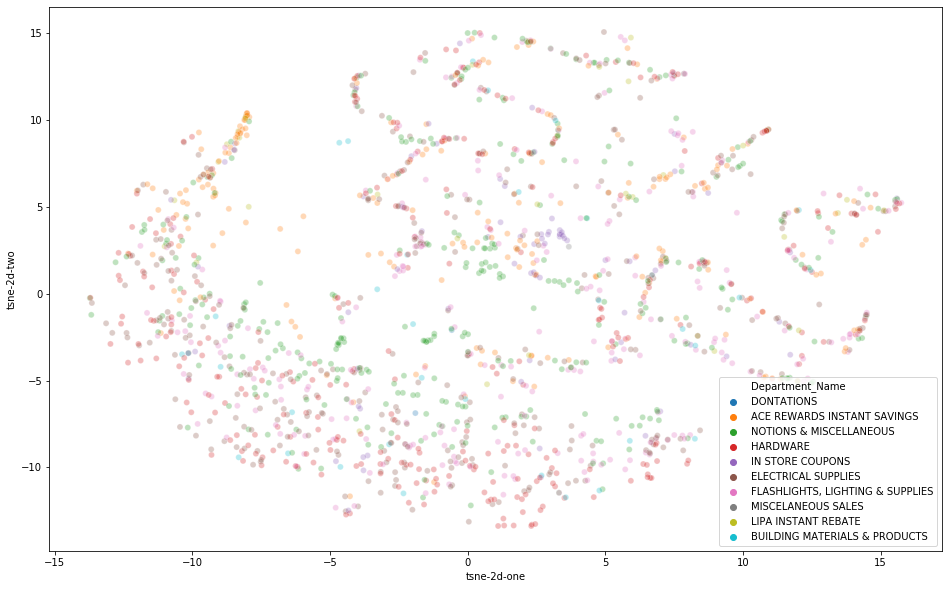

In [0]:
filter_list = uniq_deps[0:10]
df_subset2 = df_subset[df_subset['Department_Name'].isin(filter_list)]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Department_Name",
    # palette=sns.color_palette("hls", 10),
    data=df_subset2,
    legend="full",
    alpha=0.3
)

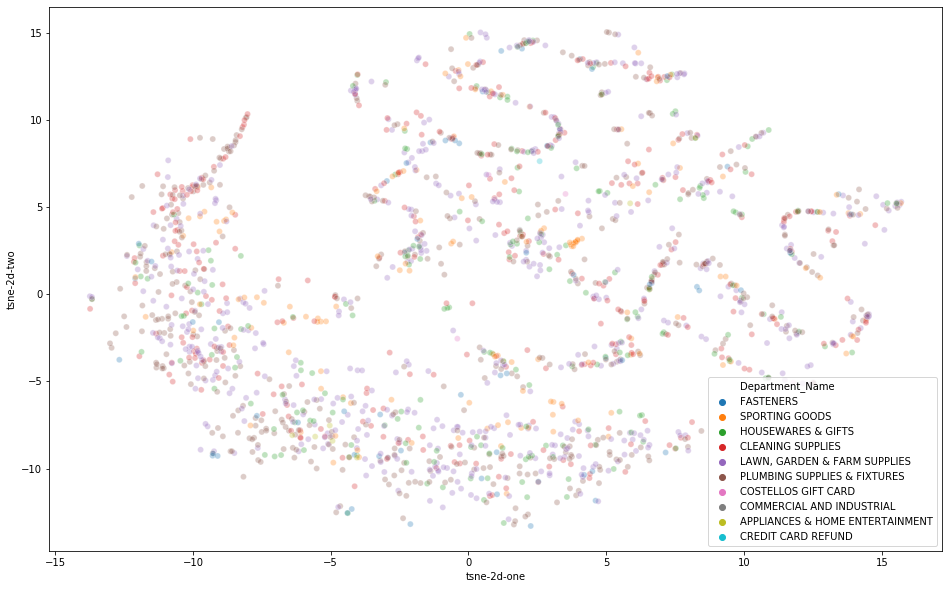

In [0]:
filter_list = uniq_deps[10:20]
df_subset2 = df_subset[df_subset['Department_Name'].isin(filter_list)]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Department_Name",
    # palette=sns.color_palette("hls", 10),
    data=df_subset2,
    legend="full",
    alpha=0.3
)

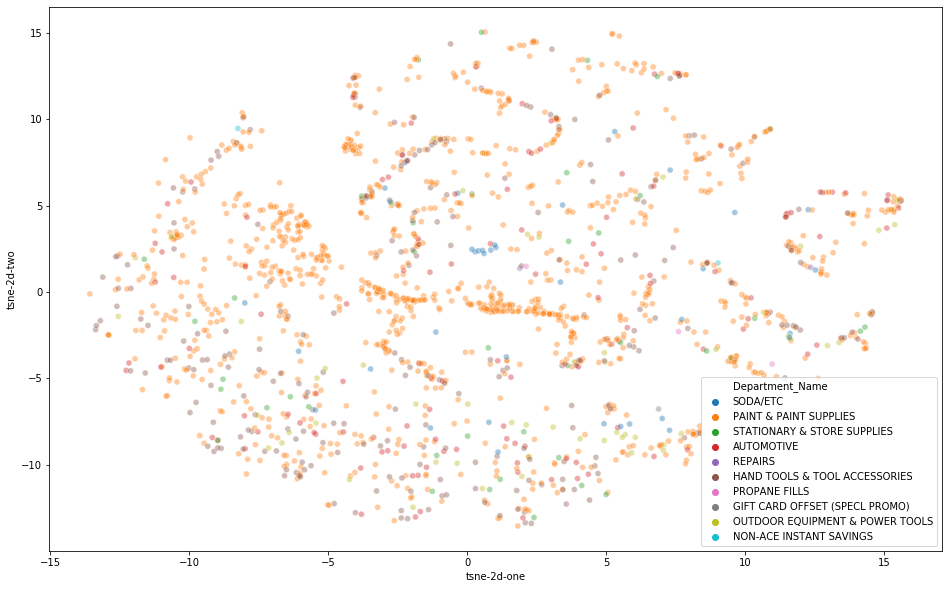

In [0]:
filter_list = uniq_deps[20:30]
df_subset2 = df_subset[df_subset['Department_Name'].isin(filter_list)]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Department_Name",
    # palette=sns.color_palette("hls", 10),
    data=df_subset2,
    legend="full",
    alpha=0.4
)

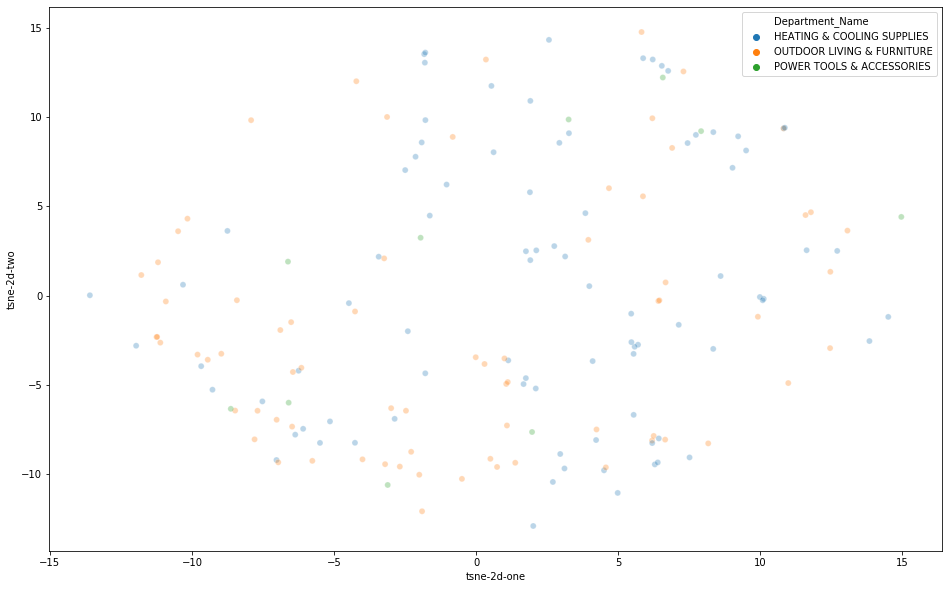

In [0]:
filter_list = uniq_deps[30:]
df_subset2 = df_subset[df_subset['Department_Name'].isin(filter_list)]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Department_Name",
    # palette=sns.color_palette("hls", 10),
    data=df_subset2,
    legend="full",
    alpha=0.3
)

# Triple2Vec

In [0]:
%pwd

'/content/grocery'

In [0]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [0]:
!git clone https://github.com/MengtingWan/grocery.git 

Cloning into 'grocery'...
remote: Enumerating objects: 34, done.
remote: Total 34 (delta 0), reused 0 (delta 0), pack-reused 34
Unpacking objects: 100% (34/34), done.


In [0]:
# f_df.to_csv('./triple2vec_data_new.csv', index=False)

In [0]:
# pd.DataFrame(pid_to_idx.values()).to_csv('./triple2vec_metadata_new.csv', index=False, header=False)

In [0]:
!zip -r triple2vec_outputs.zip ./output/

  adding: output/ (stored 0%)
  adding: output/result/ (stored 0%)
  adding: output/result/instacart_triple2vec_32_1.0_5000_5_0.8.recommendation.results.test.csv (deflated 27%)
  adding: output/result/instacart_triple2vec_32_1.0_8000_5_0.8.recommendation.results.validation.csv (deflated 28%)
  adding: output/result/instacart_triple2vec_32_1.0_12000_5_0.7.recommendation.results.validation.csv (deflated 29%)
  adding: output/result/instacart_triple2vec_32_1.0_12000_5_None.recommendation.results.test.csv (deflated 28%)
  adding: output/result/instacart_popRec.recommendation.results.validation.csv (deflated 29%)
  adding: output/result/instacart_triple2vec_32_1.0_8000_5_None.recommendation.results.validation.csv (deflated 30%)
  adding: output/result/instacart_triple2vec_32_1.0_5000_5_None.recommendation.results.validation.csv (deflated 27%)
  adding: output/result/instacart_triple2vec_32_1.0_8000_5_None.recommendation.results.test.csv (deflated 28%)
  adding: output/result/instacart_popRe

In [0]:
# ! mkdir /content/drive/My\ Drive/dsf/Project/data/triple2vec_output/

In [0]:
! cp -vr ./output/ /content/drive/My\ Drive/dsf/Project/data/22_triple2vec_output/

'./output/param/instacart_triple2vec_32_1.0_12000_5.item_emb1.csv' -> '/content/drive/My Drive/dsf/Project/data/22_triple2vec_output/output/param/instacart_triple2vec_32_1.0_12000_5.item_emb1.csv'
'./output/param/instacart_triple2vec_32_1.0_12000_5.item_emb2.csv' -> '/content/drive/My Drive/dsf/Project/data/22_triple2vec_output/output/param/instacart_triple2vec_32_1.0_12000_5.item_emb2.csv'
'./output/param/instacart_triple2vec_32_1.0_12000_5.user_emb.csv' -> '/content/drive/My Drive/dsf/Project/data/22_triple2vec_output/output/param/instacart_triple2vec_32_1.0_12000_5.user_emb.csv'
'./output/param/instacart_triple2vec_32_1.0_12000_5.item_bias.csv' -> '/content/drive/My Drive/dsf/Project/data/22_triple2vec_output/output/param/instacart_triple2vec_32_1.0_12000_5.item_bias.csv'
'./output/param/instacart_triple2vec_32_1.0_12000_5.user_bias.csv' -> '/content/drive/My Drive/dsf/Project/data/22_triple2vec_output/output/param/instacart_triple2vec_32_1.0_12000_5.user_bias.csv'
'./output/param/i

In [0]:
! cp -vr ./output/ /content/drive/My\ Drive/dsf/Project/data/triple2vec_output/

'./output/param/instacart_triple2vec_32_1.0_5000_5.item_emb1.csv' -> '/content/drive/My Drive/dsf/Project/data/triple2vec_output/output/param/instacart_triple2vec_32_1.0_5000_5.item_emb1.csv'
'./output/param/instacart_triple2vec_32_1.0_5000_5.item_emb2.csv' -> '/content/drive/My Drive/dsf/Project/data/triple2vec_output/output/param/instacart_triple2vec_32_1.0_5000_5.item_emb2.csv'
'./output/param/instacart_triple2vec_32_1.0_5000_5.user_emb.csv' -> '/content/drive/My Drive/dsf/Project/data/triple2vec_output/output/param/instacart_triple2vec_32_1.0_5000_5.user_emb.csv'
'./output/param/instacart_triple2vec_32_1.0_5000_5.item_bias.csv' -> '/content/drive/My Drive/dsf/Project/data/triple2vec_output/output/param/instacart_triple2vec_32_1.0_5000_5.item_bias.csv'
'./output/param/instacart_triple2vec_32_1.0_5000_5.user_bias.csv' -> '/content/drive/My Drive/dsf/Project/data/triple2vec_output/output/param/instacart_triple2vec_32_1.0_5000_5.user_bias.csv'
'./output/param/instacart_triple2vec_32_1.

In [0]:
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
# !mkdir ./data/
! cp /content/drive/My\ Drive/dsf/Project/data/22_triple2vec_data_new.csv ./
! cp /content/drive/My\ Drive/dsf/Project/data/22_triple2vec_metadata_new.csv ./

In [0]:
! mv ./22_triple2vec_data_new.csv ./grocery/data/instacart.data.csv

In [0]:
! mv ./22_triple2vec_metadata_new.csv ./grocery/data/instacart.meta.csv

In [0]:
%cd ./grocery/
%pwd

/content/grocery


'/content/grocery'

In [0]:
!nvidia-smi

Thu Dec  5 02:25:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Run with New PIDs

In [0]:
!python ./src/main.py --data_name instacart --mode embedding --method_name triple2vec --dim 32 --lr 1.0 --batch_size 20000 --n_neg 5

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
successfully initialized!
preparing training triples ... 
current progress for 5000000 samples:  0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 1100000, 1200000, 1300000, 1400000, 1500000, 1600000, 1700000, 1800000, 1900000, 2000000, 2100000, 2200000, 2300000, 2400000, 2500000, 2600000, 2700000, 2800000, 2900000, 3000000, 3100000, 3200000, 3300000, 3400000, 3500000, 3600000, 3700000, 3800000, 3900000, 4000000, 4100000, 4200000, 4300000, 4400000, 4500000, 4600000, 4700000, 4800000, 4900000, done!
start training instacart_triple2vec_32_1.0_20000_5 ...


2019-12-05 17:03:03.506821: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-12-05 17:03:03.507116: I tensorflow/compiler/xla/service/s

In [0]:
!python ./src/main.py --data_name instacart --mode embedding --method_name triple2vec --dim 32 --lr 1.0 --batch_size 15000 --n_neg 5

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
successfully initialized!
preparing training triples ... 
current progress for 2000000 samples:  0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 1100000, 1200000, 1300000, 1400000, 1500000, 1600000, 1700000, 1800000, 1900000, done!
start training instacart_triple2vec_32_1.0_15000_5 ...


2019-12-05 16:48:10.995752: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-12-05 16:48:10.996070: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x21c6f40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-05 16:48:10.996110: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-12-05 16:48

In [0]:
!python ./src/main.py --data_name instacart --mode embedding --method_name triple2vec --dim 32 --lr 1.0 --batch_size 12000 --n_neg 5

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
successfully initialized!
preparing training triples ... 
current progress for 500000 samples:  0, 100000, 200000, 300000, 400000, done!
start training instacart_triple2vec_32_1.0_12000_5 ...


2019-12-05 16:23:07.806659: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-12-05 16:23:07.810797: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2d82f40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-05 16:23:07.810877: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-12-05 16:23:07.904237: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-1

In [0]:
!python ./src/main.py --data_name instacart --mode recommendation --method_name triple2vec --dim 32 --lr 1.0 --batch_size 12000 --n_neg 5

## Old runs

In [0]:
!python ./src/main.py --data_name instacart --mode embedding --method_name triple2vec --dim 32 --lr 1.0 --batch_size 12000 --n_neg 5

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
successfully initialized!
preparing training triples ... 
current progress for 1000000 samples:  0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, done!
start training instacart_triple2vec_32_1.0_12000_5 ...


2019-12-05 02:49:05.764890: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
2019-12-05 02:49:05.770738: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2000179999 Hz
2019-12-05 02:49:05.770987: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x30c0f40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-05 02:49:05.771020: I tensorflow/compiler/xla/service/

In [0]:
!python ./src/main.py --data_name instacart --mode recommendation --method_name triple2vec --dim 32 --lr 1.0 --batch_size 12000 --n_neg 5

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
calculating item popularity and user-wise item frequency in training set ...
done!
evaluating validation data ... 
current progress: 0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, complete!
evaluating test data ... 
current progress: 0, 10000, 20000, 30000, 40000, complete!
done!
validation results
        auc   ndcg
all   0.500  0.091
warm  0.538  0.092
cold  0.461  0.091
test results
        auc   ndcg
all   0.501  0.091
warm  0.537  0.092
cold  0.461  0.091


In [0]:
!python ./src/main.py --data_name instacart --mode recommendation --method_name triple2vec --dim 32 --lr 1.0 --batch_size 12000 --n_neg 5 --l0 0.7

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
calculating item popularity and user-wise item frequency in training set ...
done!
udpating loyalty ... 
current user: 0, done!
evaluating validation data ... 
current progress: 0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, complete!
evaluating test data ... 
current progress: 0, 10000, 20000, 30000, 40000, complete!
done!
validation results
        auc   ndcg
all   0.714  0.276
warm  0.985  0.459
cold  0.449  0.089
test results
        auc   ndcg
all   0.715  0.278
warm  0.986  0.460
cold  0.450  0.089


In [0]:
!python ./src/main.py --data_name instacart --mode recommendation --method_name triple2vec --dim 32 --lr 1.0 --batch_size 12000 --n_neg 5 --l0 0.8

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
calculating item popularity and user-wise item frequency in training set ...
done!
udpating loyalty ... 
current user: 0, done!
evaluating validation data ... 
current progress: 0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, complete!
evaluating test data ... 
current progress: 0, 10000, 20000, 30000, 40000, complete!
done!
validation results
        auc   ndcg
all   0.714  0.276
warm  0.986  0.460
cold  0.449  0.089
test results
        auc   ndcg
all   0.716  0.278
warm  0.986  0.460
cold  0.450  0.089


## Run-2

In [0]:
!python ./src/main.py --data_name instacart --mode embedding --method_name triple2vec --dim 32 --lr 1.0 --batch_size 8000 --n_neg 5

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
successfully initialized!
preparing training triples ... 
current progress for 500000 samples:  0, 100000, 200000, 300000, 400000, done!
start training instacart_triple2vec_32_1.0_8000_5 ...


2019-12-05 02:24:43.024737: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
2019-12-05 02:24:43.029958: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2000179999 Hz
2019-12-05 02:24:43.030176: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x156ef40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-05 02:24:43.030202: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0

In [0]:
!python ./src/main.py --data_name instacart --mode recommendation --method_name triple2vec --dim 32 --lr 1.0 --batch_size 8000 --n_neg 5

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
calculating item popularity and user-wise item frequency in training set ...
done!
evaluating validation data ... 
current progress: 0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, complete!
evaluating test data ... 
current progress: 0, 10000, 20000, 30000, 40000, complete!
done!
validation results
        auc   ndcg
all   0.314  0.088
warm  0.256  0.087
cold  0.365  0.088
test results
        auc   ndcg
all   0.311  0.088
warm  0.254  0.087
cold  0.364  0.088


In [0]:
!python ./src/main.py --data_name instacart --mode recommendation --method_name triple2vec --dim 32 --lr 1.0 --batch_size 8000 --n_neg 5 --l0 0.8

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
calculating item popularity and user-wise item frequency in training set ...
done!
udpating loyalty ... 
current user: 0, done!
evaluating validation data ... 
current progress: 0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, complete!
evaluating test data ... 
current progress: 0, 10000, 20000, 30000, 40000, complete!
done!
validation results
        auc   ndcg
all   0.666  0.276
warm  0.986  0.462
cold  0.353  0.087
test results
        auc   ndcg
all   0.666  0.278
warm  0.986  0.462
cold  0.352  0.087


In [0]:
!python ./src/main.py --data_name instacart --mode recommendation --method_name popRec

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
calculating item popularity and user-wise item frequency in training set ...
done!
evaluating validation data ... 
current progress: 0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, complete!
evaluating test data ... 
current progress: 0, 10000, 20000, 30000, 40000, complete!
done!
validation results
        auc   ndcg
all   0.747  0.218
warm  0.839  0.325
cold  0.659  0.112
test results
        auc   ndcg
all   0.749  0.218
warm  0.841  0.323
cold  0.661  0.112


# Run-1

In [0]:
!python ./src/main.py --data_name instacart --mode embedding --method_name triple2vec --dim 32 --lr 1.0 --batch_size 5000 --n_neg 5


/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
successfully initialized!
preparing training triples ... 
current progress for 50000 samples:  0, done!
start training instacart_triple2vec_32_1.0_5000_5 ...


2019-12-05 01:58:38.502909: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
2019-12-05 01:58:38.508269: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2000179999 Hz
2019-12-05 01:58:38.508495: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1560f40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-05 01:58:38.508551: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-12-

In [0]:
!nvidia-smi

Thu Dec  5 03:27:46 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Recommendation

In [0]:
!python ./src/main.py --data_name instacart --mode recommendation --method_name triple2vec --dim 32 --lr 1.0 --batch_size 5000 --n_neg 5

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
calculating item popularity and user-wise item frequency in training set ...
done!
evaluating validation data ... 
current progress: 0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, complete!
evaluating test data ... 
current progress: 0, 10000, 20000, 30000, 40000, complete!
done!
validation results
        auc   ndcg
all   0.413  0.099
warm  0.336  0.100
cold  0.484  0.098
test results
        auc   ndcg
all   0.413  0.100
warm  0.337  0.101
cold  0.484  0.098


In [0]:
!python ./src/main.py --data_name instacart --mode recommendation --method_name triple2vec --dim 32 --lr 1.0 --batch_size 5000 --n_neg 5 --l0 0.8

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
calculating item popularity and user-wise item frequency in training set ...
done!
udpating loyalty ... 
current user: 0, done!
evaluating validation data ... 
current progress: 0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, complete!
evaluating test data ... 
current progress: 0, 10000, 20000, 30000, 40000, complete!
done!
validation results
        auc   ndcg
all   0.727  0.280
warm  0.986  0.463
cold  0.474  0.094
test results
        auc   ndcg
all   0.728  0.281
warm  0.987  0.464
cold  0.474  0.094


In [0]:
!python ./src/main.py --data_name instacart --mode recommendation --method_name popRec

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
calculating item popularity and user-wise item frequency in training set ...
done!
evaluating validation data ... 
current progress: 0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, complete!
evaluating test data ... 
current progress: 0, 10000, 20000, 30000, 40000, complete!
done!
validation results
        auc   ndcg
all   0.747  0.218
warm  0.839  0.325
cold  0.659  0.112
test results
        auc   ndcg
all   0.749  0.218
warm  0.841  0.323
cold  0.661  0.112


In [0]:
!python ./src/main.py --data_name instacart --mode recommendation --method_name popUserRec

/content/grocery/data/
/content/grocery/sample/
/content/grocery/model/
/content/grocery/output/param/
/content/grocery/output/result/
loading instacart data ...
done!
interactions about 5339 products and 4611 users are loaded
calculating item popularity and user-wise item frequency in training set ...
done!
evaluating validation data ... 
current progress: 0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, complete!
evaluating test data ... 
current progress: 0, 10000, 20000, 30000, 40000, complete!
done!
validation results
        auc   ndcg
all   0.736  0.279
warm  0.991  0.464
cold  0.486  0.092
test results
        auc   ndcg
all   0.736  0.281
warm  0.991  0.465
cold  0.484  0.092


In [0]:
import pandas as pd


In [0]:
fdf = pd.read_csv('./data/instacart.data.csv')

In [0]:
fdf['PID'].head(100)

0                                                   [9]
1                                          [1379, 4126]
2                                          [1465, 3595]
3                                                [2071]
4                                              [1, 245]
                            ...                        
95    [1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 80, 121, 121...
96                                                [187]
97                                                [454]
98                                            [1, 1904]
99                                   [1497, 1580, 2620]
Name: PID, Length: 100, dtype: object

# Ignore - Data files check

In [0]:
! head -n 5 ./data/instacart.data.csv

flag,UID,PID
test,0,[9]
train,1,"[1379, 4126]"
validation,2,"[1465, 3595]"
train,3,[2071]


In [0]:
# %ls

data/  LICENSE  model/  output/  README.md  sample/  src/


In [0]:
! head -n 5 ./data/placeholder.meta.csv

,PID
0,0
1,1
2,2


In [0]:
! head -n 5 ./data/instacart.meta.csv

0
1
2
3
4


In [0]:
!mv ./data/instacart.meta.csv ./data/instacart_old.meta.csv

In [0]:
! mv ../instacart.meta.csv ./data/instacart.meta.csv